<a href="https://colab.research.google.com/github/vlad-uve/CAE-MNIST/blob/main/notebooks/CAE_experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Autoencoder (CAE) — Experiment #2: Latent Space Dimensionality

This notebook explores the impact of varying the size of the latent space in the CAE architecture on the reconstruction quality of MNIST digits and training behavior.

---

## 📌 Objective

To investigate how different latent dimension sizes affect the model"s ability to reconstruct MNIST digits, as well as the influence on training dynamics. Results are compared against the baseline model.

---

## 🔁 Experiment Workflow

1. Clone the project and configure dependencies
2. Define multiple CAE variants with different latent diemnsion size configurations
3. Train each variant over 20 epochs using the Adam optimizer
4. Analyze training and validation losses, and compare reconstruction quality with the base line model
5. Make conclusions
6. Export results to GitHub

---

## 📊 Key Findings


---

## 1. 🔧 Setup

This section prepares the environment for running the experiment.

- Clone the GitHub repository  
- Import model classes and utility functions from `src/`  
- Import necessary libraries  
- Define constants


## 2. 🧠 Define Experiment Models

This section defines three CAE variants to evaluate the effect of varying latent space dimensionality:

- `experiment_2_model_1`: `latent_dim = 2` (Very small latent space)  
- `experiment_2_model_2`: `latent_dim = 8` (Small latent space)  
- `experiment_2_model_3`: `latent_dim = 64` (Large latent space)  

🟩 **Baseline model latent dimension:** `latent_dim = 32`

All other architectural and training parameters remain consistent with the baseline model:

- Convolutional filters: `[32, 32, 64]`  
- Batch sizes: 32 (train) / 500 (validation)  
- Activation: ReLU  
- Optimizer: Adam (`lr = 1e-3`)  
- Scheduler: `ReduceLROnPlateau`
- Epochs: 20 epochs


## 3. 🏋️‍♀️ Train Experiment Models

Each architecture defined in this experiment is trained sequentially using the run_model_training() function.

For each configuration:

- A model is initialized with its respective n_channels setting
- The optimizer (Adam) and scheduler (ReduceLROnPlateau) are redefined to track validation loss
- The model is trained for 20 epochs using the same dataloaders as in the baseline
- Training and validation losses are logged
- The final model and its loss history are stored for later analysis and comparison

This loop ensures that all models are trained under identical conditions, isolating the effect of latent dimension configuration


## 4. 🔍 Results and Observations

# 🛠️ Notebook Workflow
The sections below contain the actual code used to define, train, and evaluate the variant CAE models for this experiment. This includes model setup, training logic, and result generation. These blocks serve as the working core of the notebook and support the summary presented above

## 1. 🔧 Setup

In [1]:
from getpass import getpass

# get repo url
token = getpass("Paste your GitHub token")
user_name = 'vlad-uve'
repo_name = 'CAE-MNIST'
repo_url = f"https://{token}@github.com/{user_name}/{repo_name}.git"

# clone the repo
!git config --global user.email "vladislav.yushkevich.uve@gmail.com"
!git config --global user.name "vlad_uve"
!git clone {repo_url}

# append system path
import sys
sys.path.append('/content/CAE-MNIST')

Paste your GitHub token··········
Cloning into 'CAE-MNIST'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 466 (delta 108), reused 67 (delta 23), pack-reused 279 (from 1)
Receiving objects: 100% (466/466), 15.52 MiB | 23.79 MiB/s, done.
Resolving deltas: 100% (228/228), done.


In [2]:
# import core model components
from src.model import AutoEncoder, Encoder, Decoder

# import training utilities
from src.train import train_model, validate_model, run_model_training

# import data loading functions
from src.data import get_train_dataloader, get_validation_dataloader

# import evaluation helpers
from src.evaluation import get_experiment_reconstructions, get_image_samples

# import plotting functions
from src.plotting import plot_baseline_history, plot_digits_row, plot_experiment_reconstructions, plot_experiment_history

# import exporting functions
from src.export import save_experiment_files, export_experiment_files

In [3]:
# OS and file utilities
import os
import shutil

# PyTorch core modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data loading and transformations
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Model summary utility
from torchsummary import summary

# Learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Plotting
import matplotlib.pyplot as plt

# Import utility to display images directly in notebook
from IPython.display import Image, display

In [4]:
# set device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set random seed for reproducibility
torch.manual_seed(0)

## 2. 🧠 Define Experiment Models



In [5]:
# load baseline model description from file
base_model_files_path = '/content/CAE-MNIST/outputs/base_model_files'
with open(os.path.join(base_model_files_path, 'base_description.txt'), 'r') as f:
    base_description = f.read()

# print baseline model description
print(base_description)

Baseline model configuration:
- Architecture: n_channels = [32, 32, 64], latent_dim = 32
- Batch normalization: False
- Activation function: ReLU
- Optimizer: Adam (lr = 1e-3)
- Scheduler: ReduceLROnPlateau (patience = 3, factor = 0.5, threshold = 1e-3)
- Training: 20 epochs
- Train batch size: 32
- Validation batch size: 500


In [6]:
# define base model architecture and training parameters
base_n_channels = [32, 32, 64]
base_train_batch_size = 32
base_validation_batch_size = 500
base_num_epoch = 20

# initialize base dataloaders
base_train_dataloader = get_train_dataloader(batch_size=base_train_batch_size, data_dir='../data')
base_validation_dataloader = get_validation_dataloader(batch_size=base_validation_batch_size, data_dir='../data')

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.76MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.10MB/s]


In [7]:
# define experiment 21 description: testing latent dimension configurations
experiment_2_description = """
Experiment 2: effect of latent space dimensionality
Three alternative settings:
experiment_2_model_1: latent_dim = 2
experiment_2_model_2: latent_dim = 8
experiment_2_model_3: latent_dim = 64
Other parameters are the same as for the base line model
"""
print(experiment_2_description.strip())

# initialize experiment lists
experiment_2_losses = []
experiment_2_models = []

# define list of latent dimensions to test
experiment_2_latent_dim = [2, 8, 64]

Experiment 2: effect of latent space dimensionality
Three alternative settings:
experiment_2_model_1: latent_dim = 2
experiment_2_model_2: latent_dim = 8
experiment_2_model_3: latent_dim = 64
Other parameters are the same as for the base line model


## 3. 🏋️‍♀️ Train Experiment Models

In [ ]:
# run experiments with different latent sizes
for latent_dim_i in experiment_2_latent_dim:
    # create model with specific latent size
    model = AutoEncoder(
        n_channels=base_n_channels,
        latent_dim=latent_dim_i
    ).to(device)

    # define optimizer and scheduler
    base_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    base_scheduler = ReduceLROnPlateau(
        base_optimizer,
        mode='min',
        threshold=1e-3,
        patience=3,
        factor=0.5
    )

    # train model
    model, loss_history = run_model_training(
        model=model,
        train_dataloader=base_train_dataloader,
        validation_dataloader=base_validation_dataloader,
        optimizer=base_optimizer,
        scheduler=base_scheduler,
        num_epoch=base_num_epoch,
        device=device
    )

    # record results
    experiment_2_losses.append(loss_history)
    experiment_2_models.append(model)

## 4. 🔍 Results and Observations

### 4.1 📉 Loss Curves

In [8]:
# import base loss
base_loss = torch.load('/content/CAE-MNIST/outputs/base_model_files/base_loss.pth')

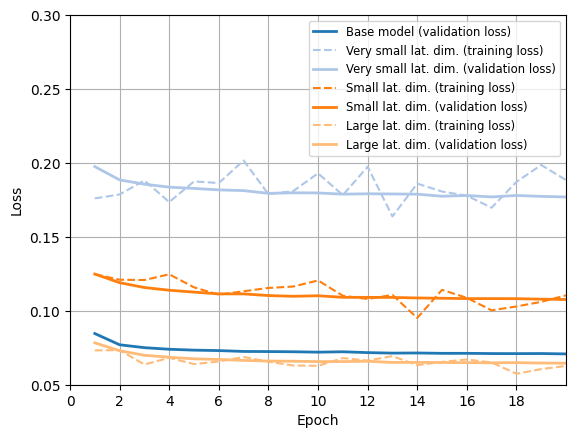

In [16]:
# plot baseeline validation loss
plot_baseline_history(base_loss)

# plot training and validation losses for experiment 2 models
plot_experiment_history(
    loss_list=experiment_2_losses,
    label_list=['Very small latent dimension', 'Small lat. dim.', 'Large lat. dim.'],
    title='',
    to_plot_train=True
)

# format plot
plt.xlim(1, base_num_epoch)
plt.xticks(range(0, base_num_epoch, 2))
plt.ylim(0.05, 0.3)
plt.legend(fontsize='small')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()

# save plot
plt.savefig("CAE-MNIST/outputs/experiment_2_files/experiment_2_image_loss.png")
plt.show()

In [17]:
# manually add and push experiment 1 loss curve image to Git repository
!git -C /content/CAE-MNIST add outputs/experiment_2_files/experiment_2_image_loss.png
!git -C /content/CAE-MNIST commit -m "Add experiment 2 loss history curve"
!git -C /content/CAE-MNIST push origin main

[main fa082c4] Add experiment 2 loss history curve
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/experiment_2_files/experiment_2_image_loss.png
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 47.83 KiB | 15.94 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   b30d1b3..fa082c4  main -> main


### 4.2

In [18]:
# get sample images and labels
sample_images, sample_labels = get_image_samples(base_validation_dataloader)

# get reconstructed images from experiment 2
experiment_2_reconstructions=get_experiment_reconstructions(experiment_2_models, sample_images, device)

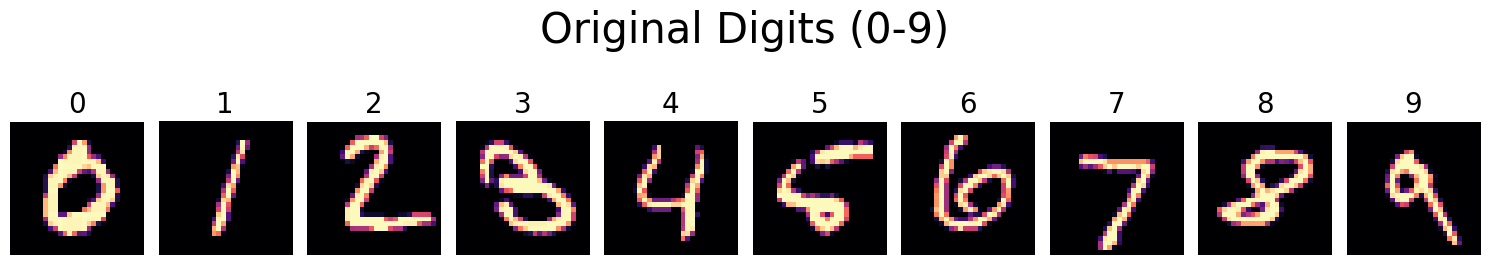

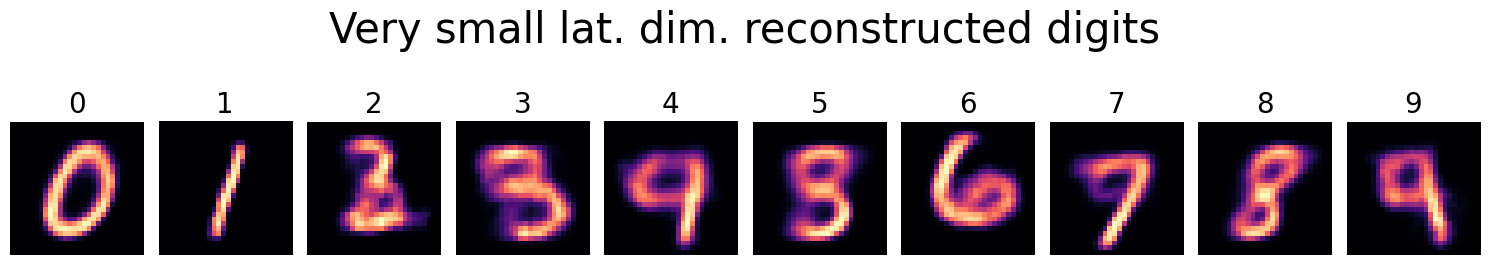

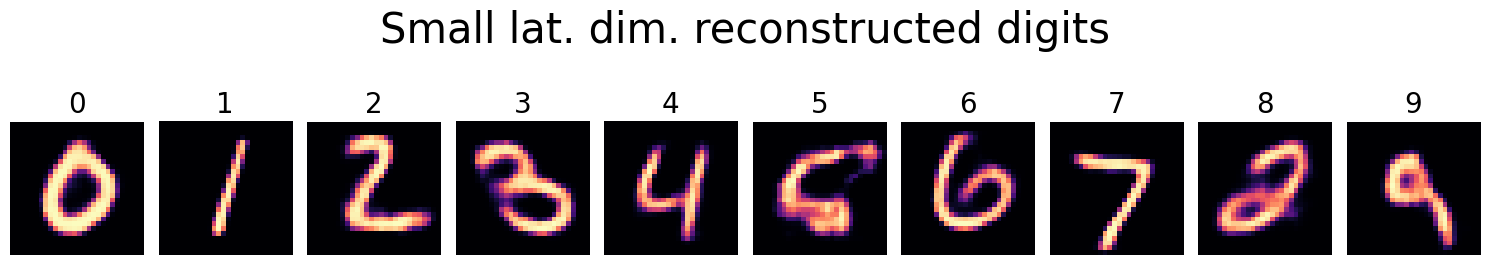

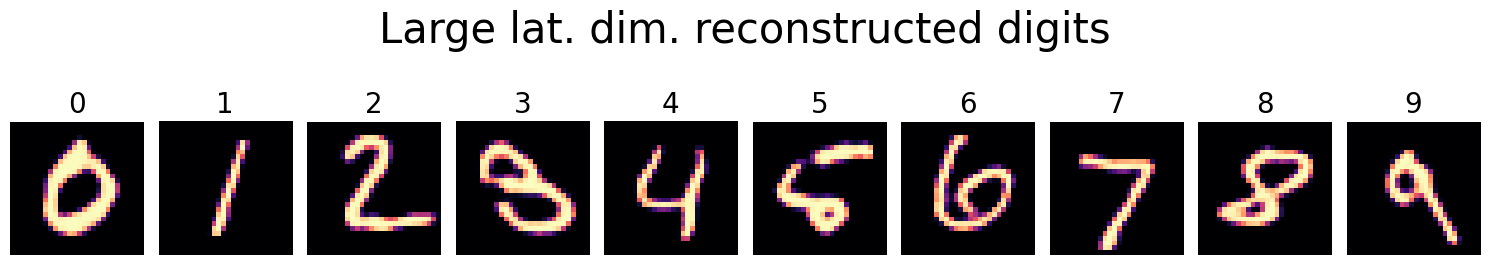

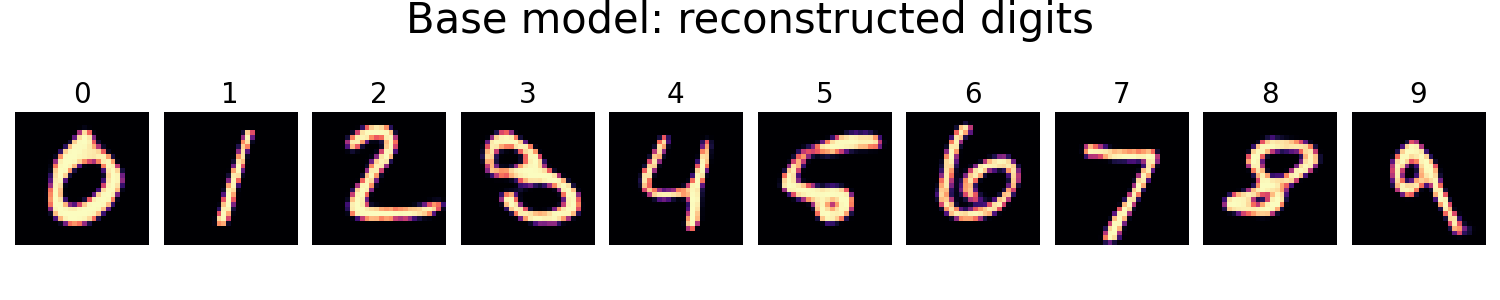

In [21]:
# display original benchmark images
plot_digits_row(sample_images.squeeze(), sample_labels, title='Original Digits (0-9)')

# display reconstructions from experiment
experiment_2_reconstruction_figures = plot_experiment_reconstructions(
    experiment_2_reconstructions,
    sample_labels,
    title_list=[
        'Very small lat. dim:',
        'Small lat. dim.',
        'Large lat. dim.'
    ]
    )

for idx, fig in enumerate(experiment_2_reconstruction_figures):
  fig.savefig(f"CAE-MNIST/outputs/experiment_2_files/experiment_2_image_reconstruction_{idx+1}.png")

# display reconsructions from baseline model
display(Image(filename='/content/CAE-MNIST/outputs/base_model_files/base_image_reconstruction.png'))
print('\n')

In [22]:
#manually add and push experiment 2 reconstruction images to Git repository
for idx, _ in enumerate(experiment_2_reconstruction_figures):
  !git -C /content/CAE-MNIST add outputs/experiment_2_files/experiment_2_image_reconstruction_{idx+1}.png

!git -C /content/CAE-MNIST commit -m "Add experiment 2 reconstructed digits"
!git -C /content/CAE-MNIST push origin main

[main d46ede9] Add experiment 2 reconstructed digits
 3 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 outputs/experiment_2_files/experiment_2_image_reconstruction_1.png
 create mode 100644 outputs/experiment_2_files/experiment_2_image_reconstruction_2.png
 create mode 100644 outputs/experiment_2_files/experiment_2_image_reconstruction_3.png
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 2 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 88.65 KiB | 5.54 MiB/s, done.
Total 7 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/vlad-uve/CAE-MNIST.git
   fa082c4..d46ede9  main -> main


## 6. 📂 Export Experiment 2 Files

In [ ]:
# save all experiment 2 outputs (models, losses, reconstructions, description)
save_experiment_files(
    experiment_name="experiment_2",
    models=experiment_2_models,
    losses=experiment_2_losses,
    reconstructions=experiment_2_reconstructions,
    description_text=experiment_2_description
)

✅ Saved experiment_2 files to: /content/CAE_experiment_2_local


In [ ]:
# export experiment 1 files to Git
export_experiment_files(
    experiment_name="experiment_2",
    model_count=len(experiment_2_models)
)

## 7. Import Experiment 2 Files

In [10]:
# define output path for experiment 2 files
outputs_path = '/content/CAE-MNIST/outputs/experiment_2_files'

# initialize storage lists
experiment_2_models = []
experiment_2_losses = []
experiment_2_reconstructions = []

# loop over latent dimension values used in experiment 2
for idx, latent_dim_i in enumerate(experiment_2_latent_dim):
    # initialize model with specified latent dimension
    model = AutoEncoder(
        n_channels=base_n_channels,
        latent_dim=latent_dim_i
    ).to(device)

    # load model weights
    model_file = f'experiment_2_model_{idx+1}.pth'
    model_path = os.path.join(outputs_path, model_file)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    experiment_2_models.append(model)

    # load loss history
    loss_file = f'experiment_2_loss_{idx+1}.pth'
    loss_path = os.path.join(outputs_path, loss_file)
    loss_history = torch.load(loss_path)
    experiment_2_losses.append(loss_history)

    # load reconstructed images
    reconstructed_file = f'experiment_2_reconstruction_{idx+1}.pth'
    reconstructed_path = os.path.join(outputs_path, reconstructed_file)
    reconstructed_images = torch.load(reconstructed_path)
    experiment_2_reconstructions.append(reconstructed_images)

# load experiment description
with open(os.path.join(outputs_path, 'experiment_2_description.txt'), 'r') as f:
    experiment_2_description = f.read()

print("✅ All Experiment 2 models, losses, reconstructed images and description loaded.")

✅ All Experiment 2 models, losses, reconstructed images and description loaded.
